# Anomaly detection for clickstream data

## Exploring data and date preparation

data source : https://github.com/hortonworks/fieldeng-modern-clickstream

In [1]:
# !gzip -d *.gz

gzip: *.gz: No such file or directory


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#### clickstreams 
- Click stream history dataset

In [4]:
cs = pd.read_csv('clickstream.tsv', header=None, delimiter='|')
cs.columns = ['clickstream_id','timestamp','IP address','url','is_purchased','is_page_errored','user_session_id','city','state','country']
cs['timestamp'] = cs['timestamp'].astype('datetime64')
cs.set_index('timestamp', inplace=True)
cs.head()

clickstream_id       IP address  \
timestamp                                              
2012-03-01 00:00:19      1330588819  147.222.227.200   
2012-03-01 00:00:25      1330588825     99.49.96.163   
2012-03-01 00:00:27      1330588827  147.222.227.200   
2012-03-01 00:00:57      1330588857     69.114.3.205   
2012-03-01 00:00:59      1330588859    71.217.29.209   

                                                url  is_purchased  \
timestamp                                                           
2012-03-01 00:00:19              http://www.RL.com/             0   
2012-03-01 00:00:25  http://www.RL.com/product/4004             0   
2012-03-01 00:00:27              http://www.RL.com/             0   
2012-03-01 00:00:57  http://www.RL.com/product/4004             0   
2012-03-01 00:00:59   http://www.RL.com/review/3004             0   

                     is_page_errored                       user_session_id  \
timestamp                                                                    
2012-03-01 00:00:19          0.00000  AF8A0FDF-B1F8-474C-8CD7-8CA06A8E435B   
2012-03-01 00:00:25          1.00000  C9183A22-6E1D-4147-BDC9-D634FC957098   
2012-03-01 00:00:27          0.00000  AF8A0FDF-B1F8-474C-8CD7-8CA06A8E435B   
2012-03-01 00:00:57          0.00000  F761B842-9DDA-42CC-9F28-A6359B6C7219   
2012-03-01 00:00:59          0.59596  6FE1CB72-95C9-47F9-A1CB-7295C927F916   

                               city state country  
timestamp                                          
2012-03-01 00:00:19         spokane    wa     usa  
2012-03-01 00:00:25         detroit    mi     usa  
2012-03-01 00:00:27         spokane    wa     usa  
2012-03-01 00:00:57  east northport    ny     usa  
2012-03-01 00:00:59          tacoma    wa     usa

- We will define the problem to analyze clicks in arbitarry time window
- We will count:
    - the number of urls(pages) that users visited
    - the number of users
    - the number of clicks

In [7]:
css = cs[['user_session_id', 'url', 'clickstream_id']].groupby(['url', 'timestamp','user_session_id']).count().reset_index()
css

url           timestamp  \
0                 http://www.RL.com/ 2012-03-01 00:00:19   
1                 http://www.RL.com/ 2012-03-01 00:00:27   
2                 http://www.RL.com/ 2012-03-01 00:01:21   
3                 http://www.RL.com/ 2012-03-01 00:01:30   
4                 http://www.RL.com/ 2012-03-01 00:01:45   
...                              ...                 ...   
397936  http://www.RL.com/video/1003 2012-03-15 23:52:13   
397937  http://www.RL.com/video/1003 2012-03-15 23:52:26   
397938  http://www.RL.com/video/1003 2012-03-15 23:53:34   
397939  http://www.RL.com/video/1003 2012-03-15 23:54:30   
397940  http://www.RL.com/video/1003 2012-03-15 23:55:38   

                             user_session_id  clickstream_id  
0       AF8A0FDF-B1F8-474C-8CD7-8CA06A8E435B               1  
1       AF8A0FDF-B1F8-474C-8CD7-8CA06A8E435B               1  
2       AF8A0FDF-B1F8-474C-8CD7-8CA06A8E435B               1  
3       60C8049D-C1A2-41C2-B503-6C1200424C49               1  
4       F761B842-9DDA-42CC-9F28-A6359B6C7219               1  
...                                      ...             ...  
397936  632959ED-DE61-43E4-A9BC-0F8E1AA6B070               1  
397937  A30C1420-DF86-DABF-50CA-F490E9338E95               1  
397938  A30C1420-DF86-DABF-50CA-F490E9338E95               1  
397939  3C9AB6C3-D275-4AA1-8BA3-CE401DBD1E98               1  
397940  89C857AE-9181-426C-8ADD-9EB098FC7CEB               1  

[397941 rows x 4 columns]

- There are 16 unique pages.

In [8]:
urls = css['url'].unique()
urls

array(['http://www.RL.com/', 'http://www.RL.com/product/4001',
       'http://www.RL.com/product/4002', 'http://www.RL.com/product/4003',
       'http://www.RL.com/product/4004', 'http://www.RL.com/product/4005',
       'http://www.RL.com/reco/2001', 'http://www.RL.com/reco/2002',
       'http://www.RL.com/review/3001', 'http://www.RL.com/review/3002',
       'http://www.RL.com/review/3003', 'http://www.RL.com/review/3004',
       'http://www.RL.com/review/3005', 'http://www.RL.com/video/1001',
       'http://www.RL.com/video/1002', 'http://www.RL.com/video/1003'],
      dtype=object)

- Count the urls in 10 minitues

In [9]:
for index, url in zip(range(len(urls)), urls):
    r = css[css['url'] == url].set_index('timestamp').resample('10T')
    clicks = r.sum()['clickstream_id']
    users  = r.nunique()['user_session_id']
    stream = pd.concat([ clicks, users], axis=1)
    stream['url'] = url
    stream = stream[['url', 'clickstream_id', 'user_session_id']]
    try:
        streams
    except NameError:
        streams = stream
    else: 
        streams = pd.concat([streams,stream])
streams

url  clickstream_id  \
timestamp                                                           
2012-03-01 00:00:00            http://www.RL.com/              24   
2012-03-01 00:10:00            http://www.RL.com/              22   
2012-03-01 00:20:00            http://www.RL.com/              20   
2012-03-01 00:30:00            http://www.RL.com/              17   
2012-03-01 00:40:00            http://www.RL.com/              15   
...                                           ...             ...   
2012-03-15 23:10:00  http://www.RL.com/video/1003               6   
2012-03-15 23:20:00  http://www.RL.com/video/1003               3   
2012-03-15 23:30:00  http://www.RL.com/video/1003               6   
2012-03-15 23:40:00  http://www.RL.com/video/1003               2   
2012-03-15 23:50:00  http://www.RL.com/video/1003               5   

                     user_session_id  
timestamp                             
2012-03-01 00:00:00               13  
2012-03-01 00:10:00               14  
2012-03-01 00:20:00                8  
2012-03-01 00:30:00                9  
2012-03-01 00:40:00                8  
...                              ...  
2012-03-15 23:10:00                4  
2012-03-15 23:20:00                3  
2012-03-15 23:30:00                5  
2012-03-15 23:40:00                2  
2012-03-15 23:50:00                4  

[34556 rows x 3 columns]

- Replace urls to page_1, 2, 3,...

In [10]:
url_new = []
for i, url in enumerate(urls):
    url_new.append('page_'+str(i))

- Clicks seem to similar each other

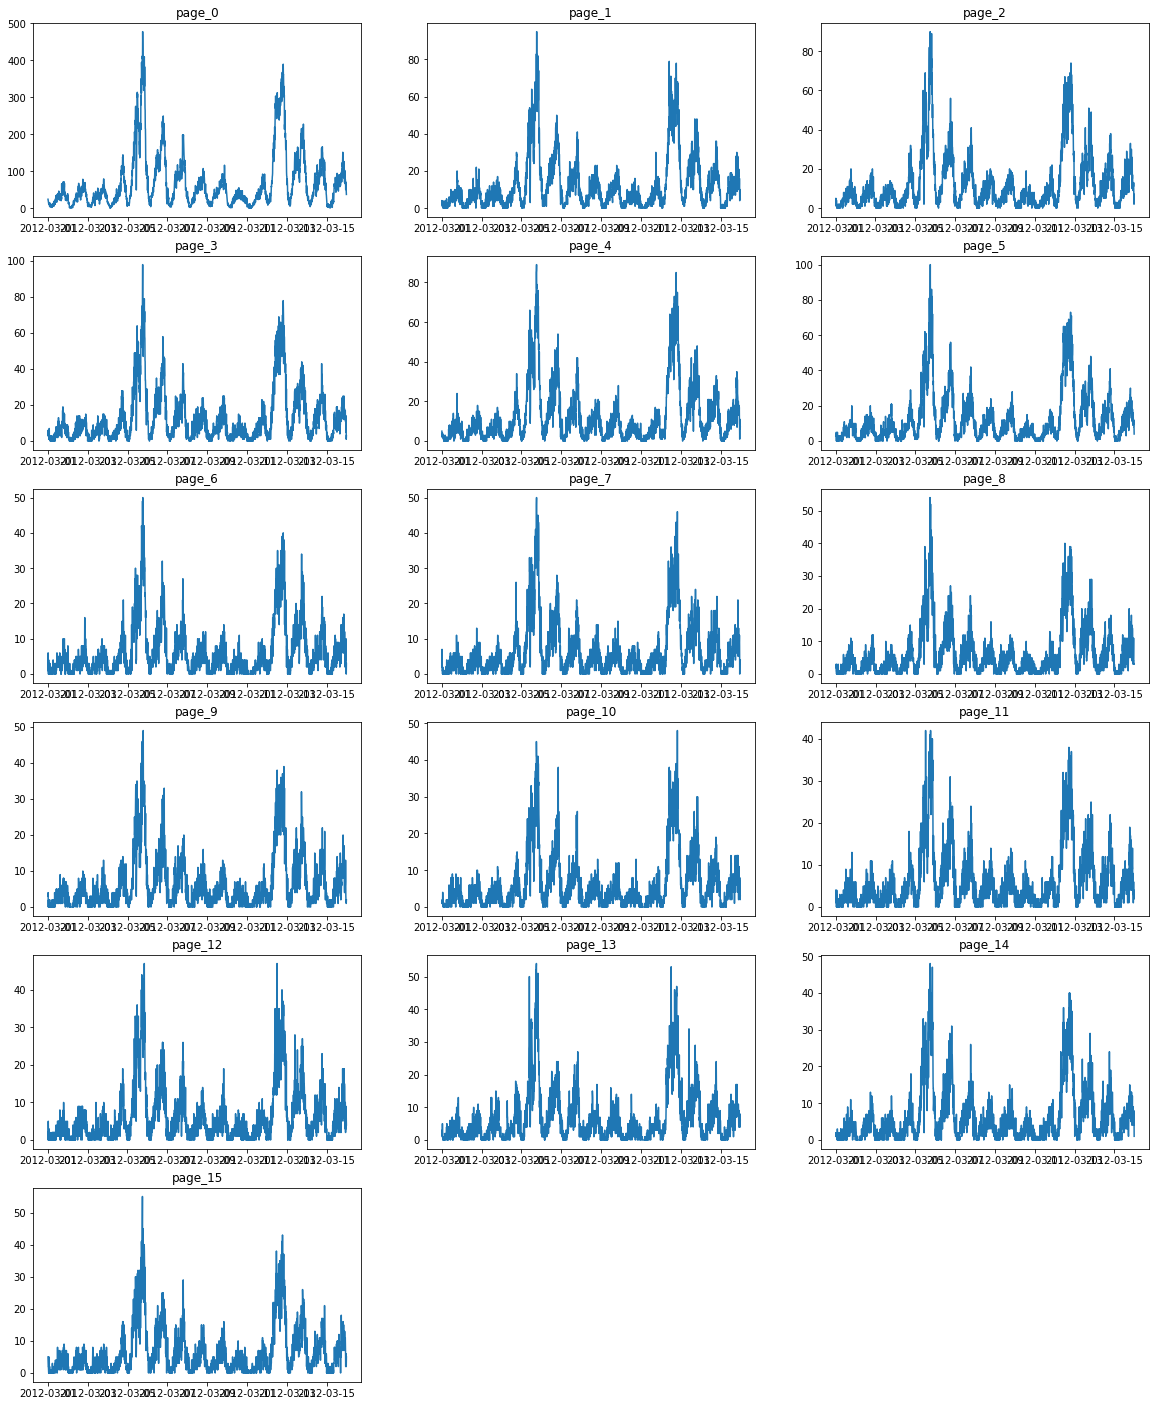

In [11]:
# css = css.groupby(['url','timestamp','user_session_id']).count().reset_index()
# # css.set_index(['url','timestamp']).resample('10T').nunique()
# urls = css.url.unique()
plt.figure(figsize=(20,25))
for index, url in zip(range(len(urls)), urls):
    r = css[css['url'] == url].set_index('timestamp').resample('10T')
    plt.subplot(6,3, index+1)
    plt.plot(r.sum()['clickstream_id'])
    plt.title(url_new[index])
    

- We will use some of varialbes in the notebook 2 and 3

In [12]:
%store urls url_new css streams

Stored 'urls' (ndarray)
Stored 'url_new' (list)
Stored 'css' (DataFrame)
Stored 'streams' (DataFrame)
